In [1]:
#!pip install transliterate
#!pip instal fasttext

In [2]:
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 856.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 42.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Uninstalling torchvision-0.16.0+cu121:
      Successfully uninstalled torchvision-0.16.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.

In [3]:
from ast import literal_eval
import json
import re
import gc
import fasttext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from scipy.sparse import coo_matrix, hstack

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, multilabel_confusion_matrix, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from torch.nn import functional as F
from tqdm.notebook import tqdm
from IPython.display import clear_output

from transformers import (
    BertTokenizer, BertForSequenceClassification, AdamW,
    get_linear_schedule_with_warmup, DistilBertTokenizer,
    AutoModelForSequenceClassification, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification, AutoModel,
    AutoTokenizer, Trainer, TrainingArguments
)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_topics = pd.read_excel('yt_topics_10_500.xlsx')

In [5]:
df_topics['topic'].value_counts().head(50)

?                                 500
Эзотерика                         494
Увлечение и хобби                 483
Авто/Мото                         473
Спорт                             471
Музыка                            471
Лайфстайл                         456
Юмор                              439
Кино                              431
Развлечения                       415
Игры                              396
Игры, Развлечения                  94
Развлечения, Юмор                  45
Кино, Развлечения                  30
Юмор, Развлечения                  28
Кино, Юмор                         21
Лайфстайл, Увлечение и хобби       17
Авто/Мото, Увлечение и хобби       14
Развлечения, Кино                  14
Музыка, Увлечение и хобби          13
Спорт, Развлечения                 11
Развлечения, Игры                  11
Юмор, Игры                         11
Спорт, Увлечение и хобби            9
Кино, Игры                          9
Юмор, Кино                          9
Музыка, Разв

Как видим, есть экземпляры с одним и несколькими классами.  
Если оставить как есть, то классы сильно несбалансированы.  
Тогда можно их присоединить к тому классу, который идет в списке первым.  
Либо удалить, чтобы не добавлять в класс смешанные экземпляры.

In [6]:
df_topics['topic_one'] = df_topics['topic'].str.split(',').apply(lambda x: x[0])

In [7]:
#df_topics = df_topics[df_topics['topic'].str.split(',').apply(len) == 1]

In [8]:
df_topics['topic_one'].value_counts().head(50)

Развлечения          500
Юмор                 500
Кино                 500
Игры                 500
Авто/Мото            500
Музыка               500
Увлечение и хобби    500
Лайфстайл            500
Эзотерика            500
Спорт                500
?                    500
Name: topic_one, dtype: int64

Как видим классы *сбалансированы*, сильных перекосов нет.

Т.к. по условию задачи метрика классификации не дана, то выберем сами.  
В качестве метрики далее будем брать **F1 score**. Можно macro или micro, на сбалансированных данных разницы нет

In [9]:
df = pd.read_csv('channals_1000.csv')
for file in ['channals_2000.csv', 'channals_3000.csv', 'channals_4000.csv', 'channals_5000.csv', 'channals_5499.csv']:
  df = pd.concat([df, pd.read_csv(file)])

In [10]:

df['video_titles'] = df['video_titles'].apply(lambda x: literal_eval(x) if pd.notna(x) else None)
df['video_descriptions'] = df['video_descriptions'].apply(lambda x: literal_eval(x) if pd.notna(x) else None)
df['video_ids'] = df['video_ids'].apply(lambda x: literal_eval(x) if pd.notna(x) else None)
df['video_published_time'] = df['video_published_time'].apply(lambda x: literal_eval(x) if pd.notna(x) else None)

In [11]:
df.head()

,index,channel_description,video_titles,video_descriptions,video_ids,video_published_time
0,0.0,"Канал называется А4, почему так? Тебе нужно за...","[24 Часа в ИГЛУ ! * ВЫЖИВАНИЕ 1 ЧАС ВЛОГ *, Эк...",[Официальный мерч А4 : https://a4shop.ru\n\nМы...,"[OH2s8vQAWug, zzc4oXazwrg, HPcp0TOhZRo, yLftCk...","[2024-01-31T12:01:30Z, 2024-01-29T12:01:02Z, 2..."
1,1.0,"Здесь можно поржать, отложить кирпичей, снять ...",[ОГРОМНАЯ ЗМЕЮКА ► Resident Evil HD Remaster #...,[Прохождение Resident Evil HD Remaster. Всем п...,"[A98M-aUIgXI, vGDjLQDHPxw, CXiCyvBYtzA, Mx6_vS...","[2024-01-30T15:00:07Z, 2024-01-29T15:01:00Z, 2..."
2,2.0,Всем спасибо за подписку❤️\n\n,"[ИДЕАЛЬНАЯ ШКОЛА (смешное видео, приколы, юмор...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[e6vFQn0Oegs, Sb5iouUNKw4, -FnQETxkvNs, pF9zuj...","[2024-01-30T13:00:36Z, 2024-01-28T13:00:24Z, 2..."
3,3.0,"Я не знаю, зачем создал этот канал, но он врод...","[Самый Везучий Выиграет 200.000! (Горилла, Кор...",[Горы кэшбэка с Tinkoff Premium — https://l.ti...,"[PnLS-kbwbog, ygkDbP3wz9U, X7a7VNC-ZmM, rbKpcX...","[2024-01-31T17:39:26Z, 2024-01-13T15:09:39Z, 2..."
4,4.0,❌Самый молодой режиссёр страны❌\nСнимаю фильмы...,[❌Дети совсем с ума сошли со «Слова пацана» #...,"[, , , СЕРИАЛ УЖЕ ВЫШЕЛ. СМОТРИТЕ ЕГО ЗДЕСЬ: h...","[HJVY8QscD7E, iaZaxLWQMek, KnKOsdZxYs4, eUUMNx...","[2023-12-27T14:39:30Z, 2023-12-20T16:12:07Z, 2..."


У нас есть выгруженные данные по API для каждого канала и его 50 последних видео:  описание канала, список названий видео, список описаний к видео, список даты выхода видео.

### Исследуем выгруженные с ютюба данные

<Axes: >

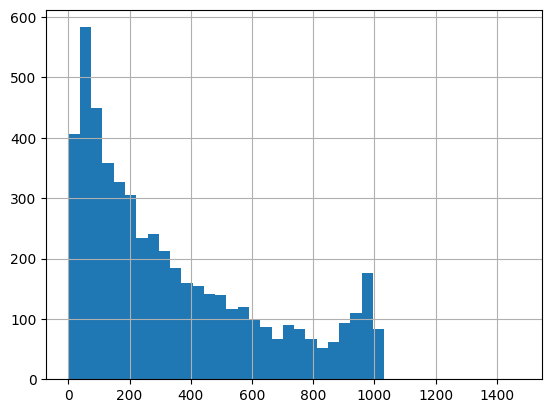

In [12]:
df['channel_description'].str.len().hist(bins=40)

Видно, что большая часть описаний видео имеет малую длину (менее 100 символов), плюс большой процент описания не информативен или является ссылкой на соц сети.  
По такис данным, сложно определять категории.
Как далее показали попытки использовать эти данные выше 0.52 F1-macro получить не удалось.

<Axes: >

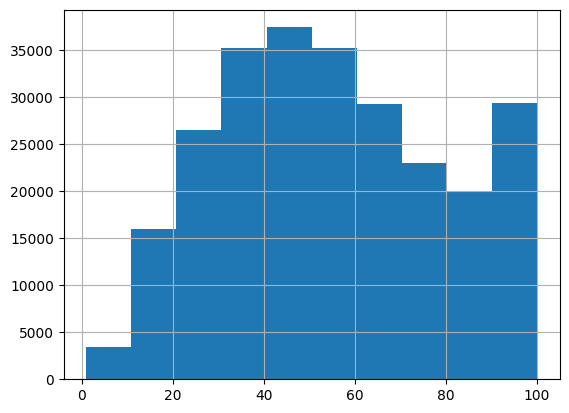

In [13]:
df.explode('video_titles')['video_titles'].str.len().hist()

Если взять все названия к видео, вне привязки к каналам, то мы видим, что длинна текста в основном около 50 символов.  
Это не так много, но около нулевых длин мало.  
Такое распределение выглядит перспективыным.  
Плюс в названиях пытаются отразить суть видео, что далеко не всего может отражать категорию, но уже блико.  

<Axes: >

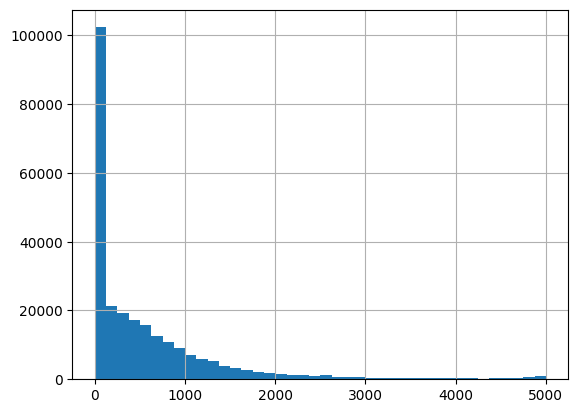

In [14]:
df.explode('video_descriptions')['video_descriptions'].str.len().hist(bins=40)

Описание к видео в большинстве своем пустое. Плюс большая часть информации это реклама и ссылки на соцсети.  
Такие данные не подойдут для обучения

#### Вывод  
Далее будем использовать названи к видео и попытаемся их при их помощи построить классификатор.  

### Обучение моделей

#### Подготовка данных

* Объединим размеченные данные с выгруженной информаций о каналах.  
* Сделаем словарь классов для токенизации нашего таргета.  
* А также отчистим от пропусков, которые возникли из-за того, что при выгрузке некоторые каналы не доступны или заблокированы.

In [15]:
df = df_topics.reset_index().merge(df, on='index', how='left')

In [16]:
target_dict = {}
for id, i in enumerate(sorted(df['topic_one'].unique())):
  target_dict[i] = id
print(target_dict)


{'?': 0, 'Авто/Мото': 1, 'Игры': 2, 'Кино': 3, 'Лайфстайл': 4, 'Музыка': 5, 'Развлечения': 6, 'Спорт': 7, 'Увлечение и хобби': 8, 'Эзотерика': 9, 'Юмор': 10}


In [17]:
df['topic_one'].value_counts()

Развлечения          500
Юмор                 500
Кино                 500
Игры                 500
Авто/Мото            500
Музыка               500
Увлечение и хобби    500
Лайфстайл            500
Эзотерика            500
Спорт                500
?                    500
Name: topic_one, dtype: int64

In [18]:
df['target_token'] = df['topic_one'].apply(lambda x: target_dict[x])

In [19]:
df['target_token'].value_counts()

6     500
10    500
3     500
2     500
1     500
5     500
8     500
4     500
9     500
7     500
0     500
Name: target_token, dtype: int64

In [20]:
df.head()

,index,url,topic,topic_one,channel_description,video_titles,video_descriptions,video_ids,video_published_time,target_token
0,0,http://www.youtube.com/channel/UC2tsySbe9TNrI-...,"Развлечения, Юмор",Развлечения,"Канал называется А4, почему так? Тебе нужно за...","[24 Часа в ИГЛУ ! * ВЫЖИВАНИЕ 1 ЧАС ВЛОГ *, Эк...",[Официальный мерч А4 : https://a4shop.ru\n\nМы...,"[OH2s8vQAWug, zzc4oXazwrg, HPcp0TOhZRo, yLftCk...","[2024-01-31T12:01:30Z, 2024-01-29T12:01:02Z, 2...",6
1,1,http://www.youtube.com/channel/UCdKuE7a2QZeHPh...,"Юмор, Игры",Юмор,"Здесь можно поржать, отложить кирпичей, снять ...",[ОГРОМНАЯ ЗМЕЮКА ► Resident Evil HD Remaster #...,[Прохождение Resident Evil HD Remaster. Всем п...,"[A98M-aUIgXI, vGDjLQDHPxw, CXiCyvBYtzA, Mx6_vS...","[2024-01-30T15:00:07Z, 2024-01-29T15:01:00Z, 2...",10
2,2,http://www.youtube.com/channel/UCE7f6y9VGVdZEt...,Юмор,Юмор,Всем спасибо за подписку❤️\n\n,"[ИДЕАЛЬНАЯ ШКОЛА (смешное видео, приколы, юмор...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[e6vFQn0Oegs, Sb5iouUNKw4, -FnQETxkvNs, pF9zuj...","[2024-01-30T13:00:36Z, 2024-01-28T13:00:24Z, 2...",10
3,3,http://www.youtube.com/channel/UC6JRrn_7Qe1CZB...,Развлечения,Развлечения,"Я не знаю, зачем создал этот канал, но он врод...","[Самый Везучий Выиграет 200.000! (Горилла, Кор...",[Горы кэшбэка с Tinkoff Premium — https://l.ti...,"[PnLS-kbwbog, ygkDbP3wz9U, X7a7VNC-ZmM, rbKpcX...","[2024-01-31T17:39:26Z, 2024-01-13T15:09:39Z, 2...",6
4,4,http://www.youtube.com/channel/UC7VUPJfRyt57Xo...,Кино,Кино,❌Самый молодой режиссёр страны❌\nСнимаю фильмы...,[❌Дети совсем с ума сошли со «Слова пацана» #...,"[, , , СЕРИАЛ УЖЕ ВЫШЕЛ. СМОТРИТЕ ЕГО ЗДЕСЬ: h...","[HJVY8QscD7E, iaZaxLWQMek, KnKOsdZxYs4, eUUMNx...","[2023-12-27T14:39:30Z, 2023-12-20T16:12:07Z, 2...",3


In [21]:
df['video_titles'].isna().sum()

207

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5500 entries, 0 to 5499
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 5500 non-null   int64 
 1   url                   5500 non-null   object
 2   topic                 5500 non-null   object
 3   topic_one             5500 non-null   object
 4   channel_description   5198 non-null   object
 5   video_titles          5293 non-null   object
 6   video_descriptions    5293 non-null   object
 7   video_ids             5293 non-null   object
 8   video_published_time  5293 non-null   object
 9   target_token          5500 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 472.7+ KB


In [23]:
df = df.dropna()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5198 entries, 0 to 5498
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 5198 non-null   int64 
 1   url                   5198 non-null   object
 2   topic                 5198 non-null   object
 3   topic_one             5198 non-null   object
 4   channel_description   5198 non-null   object
 5   video_titles          5198 non-null   object
 6   video_descriptions    5198 non-null   object
 7   video_ids             5198 non-null   object
 8   video_published_time  5198 non-null   object
 9   target_token          5198 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 446.7+ KB


#### Удаление "мусора" из текста  
Удалим все симполы, которые не являются буквой.  
Удалим все символы контроля.  


In [25]:
def remove_accented_chars(sentence):
  t = []
  for x in sentence:
    # Используйте 'NFKC' для русского языка
    x = unicodedata.normalize('NFKC', x)

    # Удалите символы, которые не являются буквами русского алфавита
    x = ''.join(char for char in x if char.isalpha() or char.isspace())
    t.append(x)
  return t

def remove_control_characters(sentence):
    t = []
    for x in sentence:
        pattern = re.compile(r'[\n\t\r\\\'\"]')
        cleaned_text = re.sub(pattern, ' ', x)
        t.append(cleaned_text)
    return t

Попробуем применить TFIDF, BERT, FastText к нашим данным и посмотрим на результат.

#### TFIDF с explode  

TFIDF хорошо подходится для решения такой задачи, т.к. связанного контекста у нас в названиях мало, сами они короткие, слова часто просто перечисляются.  
Оценивать отношение к той или иной категории будет эффективнее просто по встречаемости отдельных слов.  
У нас для каждого канала списко с названиями видео. Мы можем либо их объединить в одну строку и отправить в алгоритм, либо развернуть списко и сделать каждое название экземпляром класса, которое присвоено каналу.  
По идее результат должен быть одинаковый.

Отчистим данные от "мусора"

In [26]:
df['video_titles_clean'] = df['video_titles'].apply(remove_control_characters).apply(remove_accented_chars).apply(lambda x: ''.join(x))

In [27]:
df['video_titles_clean'].head()

0     Часа в ИГЛУ   ВЫЖИВАНИЕ  ЧАС ВЛОГ Экстремальн...
1    ОГРОМНАЯ ЗМЕЮКА  Resident Evil HD Remaster КУП...
2    ИДЕАЛЬНАЯ ШКОЛА смешное видео приколы юмор пор...
3    Самый Везучий Выиграет  Горилла Кореш Коффи Ди...
4    Дети совсем с ума сошли со Слова пацана  lostm...
Name: video_titles_clean, dtype: object

Разделим на обучающую и тестовую выборку, сделаем ее стратифицированной, несмотря на то, что у нас выборка практически сбалансирована.

In [28]:
train, test, y_train, y_test = train_test_split(df['video_titles'], df['target_token'], test_size=0.2, random_state=42, stratify=df['target_token'])

Создадим новый датафрем с развернутыми из списков названиями видео

In [29]:
df_test = pd.DataFrame()
df_test['test'] = test
df_test['y_test'] = y_test

df_train = pd.DataFrame()
df_train['train'] = train
df_train['y_train'] = y_train

train = df_train.explode('train').reset_index()
test = df_test.explode('test').reset_index()

In [30]:
print('Кол-во образцов в тренировочной выборке: ', len(train))
print()
train.head()


Кол-во образцов в тренировочной выборке:  200798



,index,train,y_train
0,3516,#юляшереметьева 26.01.24,5
1,3516,Дуэт Юля Шереметьева (гр Леди) и Сергей Васюта...,5
2,3516,За кулисами Вегас Сити Холл #юляшереметьева #г...,5
3,3516,Юля и русская зима 🥶😯 #юляшереметьева,5
4,3516,Раскрываю секреты моей фотосессии 🤫📸 #юляшерем...,5


In [31]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('russian'), ngram_range=(1,1))
X_train = tfidf.fit_transform(train['train'])
X_test = tfidf.transform(test['test'])

In [32]:
X_train

<200798x155724 sparse matrix of type '<class 'numpy.float64'>'
	with 1277910 stored elements in Compressed Sparse Row format>

In [33]:
model = LogisticRegression(solver='sag', class_weight='balanced')

In [34]:
model.fit(X_train, train['y_train'])

LogisticRegression(class_weight='balanced', solver='sag')

In [35]:
y_pred = model.predict(X_test)
test['y_pred'] = y_pred

"Завернем" предсказанные классы видео обратно в каналы и присвоим каналу тот класс, которого больше всего.

In [36]:
 test_data_modefied = test.groupby('index')['y_pred', 'y_test'].agg(lambda x: np.bincount(x).argmax())

<ipython-input-36-630ea2e71c51>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data_modefied = test.groupby('index')['y_pred', 'y_test'].agg(lambda x: np.bincount(x).argmax())


Классы присвоенные каждому каналу по сгруппированным предсказаниям класса входящих видео
              precision    recall  f1-score   support

           0       0.47      0.30      0.37        63
           1       0.83      0.94      0.88        98
           2       0.77      0.90      0.83        98
           3       0.76      0.68      0.71        96
           4       0.45      0.55      0.49        97
           5       0.79      0.80      0.79        98
           6       0.30      0.26      0.28        96
           7       0.92      0.96      0.94        97
           8       0.81      0.83      0.82       100
           9       0.83      0.95      0.89       100
          10       0.65      0.47      0.55        97

    accuracy                           0.71      1040
   macro avg       0.69      0.69      0.69      1040
weighted avg       0.70      0.71      0.70      1040



<Axes: >

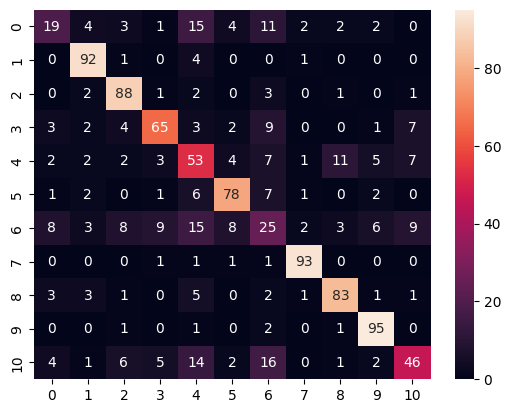

In [37]:
print('Классы присвоенные каждому каналу по сгруппированным предсказаниям класса входящих видео')
print(classification_report(test_data_modefied['y_test'], test_data_modefied['y_pred'], zero_division=0))
sns.heatmap(confusion_matrix(test_data_modefied['y_test'], test_data_modefied['y_pred']), annot=True)


Классы присвоенному каждому видео без группировки по каналам
              precision    recall  f1-score   support

           0       0.26      0.26      0.26      2748
           1       0.71      0.74      0.73      4866
           2       0.70      0.69      0.70      4667
           3       0.59      0.54      0.56      4642
           4       0.34      0.42      0.38      4794
           5       0.65      0.55      0.60      4756
           6       0.25      0.23      0.24      4767
           7       0.72      0.75      0.73      4711
           8       0.63      0.67      0.65      4966
           9       0.71      0.76      0.73      4873
          10       0.48      0.40      0.43      4661

    accuracy                           0.56     50451
   macro avg       0.55      0.55      0.55     50451
weighted avg       0.56      0.56      0.56     50451



<Axes: >

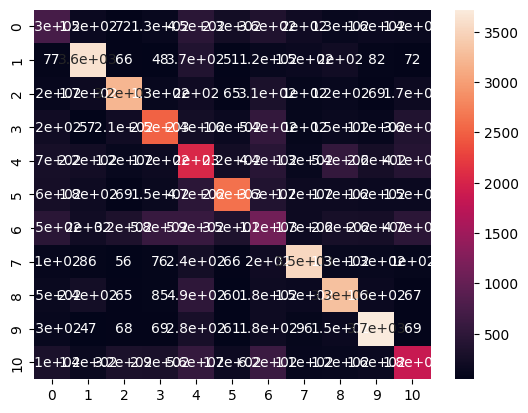

In [38]:
print('Классы присвоенному каждому видео без группировки по каналам')
print(classification_report(test['y_test'], y_pred, zero_division=0))
sns.heatmap(confusion_matrix(test['y_test'], y_pred), annot=True)


По отдельным видео видно,что классификатор работает хуже, но как видно было ранее, после группировки метрика подрастает

Кросс валидацию тут проводить не будем, т.к. тут надо аккуратнно делить выборку, т.к. видео из одного канала нужно держать вместе.  
Сделаем следующем этапе  

#### TFIDF без explode

А теперь просто соединими наши названия в одну строку и передадми TFIDF

In [39]:
df['video_titles'].apply(lambda x: ''.join(x))

0       24 Часа в ИГЛУ ! * ВЫЖИВАНИЕ 1 ЧАС ВЛОГ *Экстр...
1       ОГРОМНАЯ ЗМЕЮКА ► Resident Evil HD Remaster #3...
2       ИДЕАЛЬНАЯ ШКОЛА (смешное видео, приколы, юмор,...
3       Самый Везучий Выиграет 200.000! (Горилла, Коре...
4       ❌Дети совсем с ума сошли со «Слова пацана»  #l...
                              ...                        
5492    04 08 2023 Дилиёр & Махлия часть 203 11 2023 6...
5493    #стандофф2 #best #standoff2 #игры #мувик #демк...
5495    12 августа 2023 г.Таалай Кожомкулов: "Токойчу ...
5497    Смешной анекдот в миреАнекдоты самыеСамый смеш...
5498    wild outdoor Growerz prod. АУТ 2023. Финальная...
Name: video_titles, Length: 5198, dtype: object

In [40]:
train, test, y_train, y_test = train_test_split(df['video_titles'].apply(remove_accented_chars).apply(remove_control_characters).apply(lambda x: ''.join(x)), df['target_token'], test_size=0.2, random_state=42, stratify=df['target_token'])

In [41]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('russian'), ngram_range=(1,1))
X_train = tfidf.fit_transform(train)
X_test = tfidf.transform(test)

In [42]:
X_train

<4158x271342 sparse matrix of type '<class 'numpy.float64'>'
	with 648840 stored elements in Compressed Sparse Row format>

In [43]:
model = LogisticRegression(solver='sag', class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', solver='sag')

In [44]:
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.47      0.41      0.44        63
           1       0.92      0.90      0.91        98
           2       0.77      0.86      0.81        98
           3       0.70      0.70      0.70        96
           4       0.50      0.54      0.51        97
           5       0.76      0.82      0.79        98
           6       0.35      0.36      0.36        96
           7       0.87      0.95      0.91        97
           8       0.85      0.82      0.83       100
           9       0.87      0.89      0.88       100
          10       0.65      0.45      0.53        97

    accuracy                           0.71      1040
   macro avg       0.70      0.70      0.70      1040
weighted avg       0.71      0.71      0.71      1040



<Axes: >

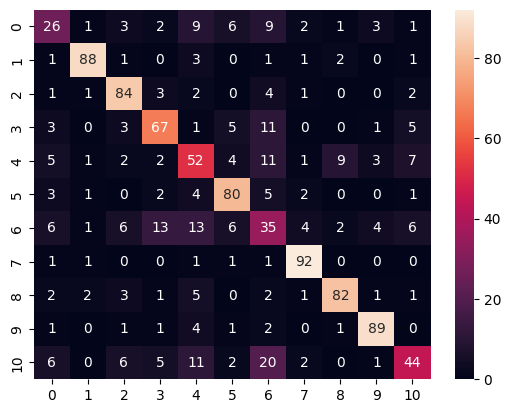

In [45]:
print(classification_report(y_test, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

##### Проведем кроссвалидацию, посмотрим на стабильность работы модели.

In [46]:

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train.to_list(), cv=stratified_kfold, scoring='f1_macro')

In [47]:
scores

array([0.7071333 , 0.68321646, 0.69054668, 0.65416578, 0.69436669,
       0.69291317, 0.67557713, 0.67685101, 0.67012971, 0.70900151])

Как видим, разброс F1 не большой, можно считать, что модель работает стабильно на этих данных.

#### TFIDF description channal

Для интереса посмотрим, что нам даст предсказание по описанию каналов. Казалось бы это должен быть самый информативный источник, исходя из его названия.

In [48]:
train, test, y_train, y_test = train_test_split(df['channel_description'], df['target_token'], test_size=0.2, random_state=42, stratify=df['target_token'])

In [49]:
train

3516    Привет! Я певица Юлия Шереметьева\nДобро пожал...
4079    По вопросу личной консультации WhatsApp +79870...
3700                                   За подписку мяукаю
2129    Добро пожаловать на наш канал. Нас зовут Крист...
1252    Привет) Меня зовут Алёна, можешь называть меня...
                              ...                        
590     https://vk.com/realpepperofficial - Мой паблик...
1990    Блог о уборке, организации хранения и классных...
2080    Популярность фигурного катания в России в посл...
446     Если Смог Прочитать - Подпишись 💕🗡️\n\nСотрудн...
2925    Меня Зовут Антон)\nВсё ещё лучшие пивные обзор...
Name: channel_description, Length: 4158, dtype: object

In [50]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('russian'), ngram_range=(1,1))
X_train = tfidf.fit_transform(train)
X_test = tfidf.transform(test)

In [51]:
X_train

<4158x38785 sparse matrix of type '<class 'numpy.float64'>'
	with 134755 stored elements in Compressed Sparse Row format>

In [52]:
model = LogisticRegression(solver='sag', class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', solver='sag')

In [53]:
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.21      0.24      0.22        63
           1       0.62      0.61      0.62        98
           2       0.56      0.65      0.60        98
           3       0.59      0.56      0.58        96
           4       0.45      0.45      0.45        97
           5       0.69      0.59      0.64        98
           6       0.28      0.28      0.28        96
           7       0.69      0.60      0.64        97
           8       0.62      0.66      0.64       100
           9       0.71      0.78      0.74       100
          10       0.47      0.42      0.44        97

    accuracy                           0.54      1040
   macro avg       0.54      0.53      0.53      1040
weighted avg       0.55      0.54      0.54      1040



<Axes: >

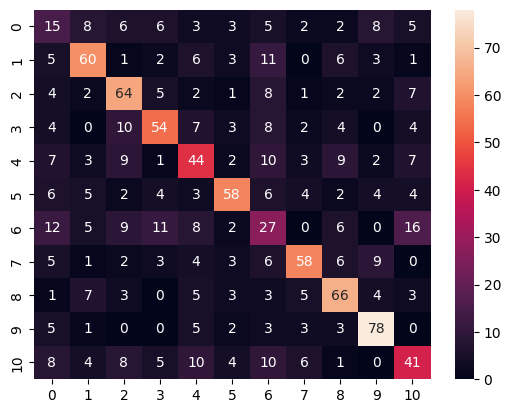

In [54]:
print(classification_report(y_test, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

### Вывод  
Обучили 3 разных модели TFIDF.  
В целом лучше всего просто объединить названия видео в одно и на нем обучать TFIDF.  F1 = 0.7 это не так плохо, но хотелось бы лучше.  
Эксперемент с классификацией по описаниям каналов не удался, F1 = 0.5, что очень мало.  
Остается учиться и предсказывать только на названиях видео.

#BERT

In [55]:
def f1_score_func_m(preds, labels, average='binary'):
    """
    Вычисляет F1-меру для многоклассовой или бинарной классификации.

    Параметры:
    - preds: numpy array, прогнозы модели
    - labels: numpy array, истинные метки
    - average: строка, опциональный параметр, задающий тип усреднения (по умолчанию 'binary')

    Возвращает:
    - f1_score: float, F1-мера
    """

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    f1 = f1_score(labels_flat, preds_flat, average=average)

    return f1

In [56]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [57]:
train, test, y_train, y_test = train_test_split(df['video_titles'], df['target_token'], test_size=0.2, random_state=42, stratify=df['target_token'])

In [58]:
df_test = pd.DataFrame()
df_test['test'] = test
df_test['y_test'] = y_test

df_train = pd.DataFrame()
df_train['train'] = train
df_train['y_train'] = y_train

train = df_train.explode('train').reset_index()
test = df_test.explode('test').reset_index()

In [59]:
HF = 'DeepPavlov/rubert-base-cased'

In [60]:
tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [61]:
encoded_data_train = tokenizer.batch_encode_plus(
    train['train'].to_list(),
    padding=True,
    truncation=True,
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors='pt',
    max_length=512


)

encoded_data_test = tokenizer.batch_encode_plus(
    test['test'].to_list(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    return_tensors='pt',
    max_length=512,
    truncation=True
)

In [62]:
  train_seq = encoded_data_train['input_ids']
  train_mask = encoded_data_train['attention_mask']
  train_y = torch.tensor(train['y_train'].tolist())


  test_seq = encoded_data_test['input_ids']
  test_mask = encoded_data_test['attention_mask']
  test_y = torch.tensor(test['y_test'].tolist())

In [63]:
  batch_size = 3000
  train_data = TensorDataset(train_seq, train_mask, train_y)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

  test_data =  TensorDataset(test_seq, test_mask, test_y)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)


In [64]:
# сбор и отчистка мусора перед обучением
import gc
gc.collect()
torch.cuda.empty_cache()

In [65]:
model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(y_train)), ignore_mismatched_sizes=True)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [66]:
epochs = 100

optimizer = AdamW(model.parameters(), lr=1e-5)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=10, num_training_steps=total_steps)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Выберем слои, которые будем обучать

In [67]:
for n,p in model.named_parameters():
  if 'classifier' in n:
    p.requires_grad = True
  else:
    p.requires_grad = False

Данный код закомменирован, т.к. выполняется долго.

In [68]:
# best_valid_loss = float('inf')
# train_losses = []
# valid_losses = []
# f_scores = []


# for epoch in range(epochs):

#     #train
#     model.train()
#     total_loss, total_accuracy = 0, 0
#     total_preds = []
#     for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
#       batch = [r.to(device) for r in batch]
#       labels = batch[2].to(device)
#       output = {'input_ids': batch[0],'attention_mask' : batch[1]}

#       preds = model(**output)
#       preds = preds['logits']
#       loss = criterion(preds, labels)
#       total_loss += loss.item()

#       loss.backward()
#       #torch.nn.utils.clip_grad_norm_(model.parameters(), 1,0)
#       optimizer.step()
#       scheduler.step()
#       optimizer.zero_grad()
#       preds = preds.detach().cpu().numpy()
#       total_preds.append(preds)

#     avg_loss = total_loss / len(train_dataloader)
#     total_preds = np.concatenate(total_preds, axis = 0)

#     #eval
#     model.eval()

#     eval_total_loss, eval_total_accuracy = 0,0
#     eval_total_preds = []
#     eval_total_labels = []

#     for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
#         batch = [t.to(device) for t in batch]
#         output = {'input_ids': batch[0],'attention_mask' : batch[1]}
#         labels = batch[2].to(device)

#         with torch.no_grad():
#             preds = model(**output)
#             preds = preds['logits']
#             loss = criterion(preds, labels)
#             eval_total_loss = total_loss + loss.item()
#             preds = preds.detach().cpu().numpy()
#             labels = labels.detach().cpu().numpy()
#             eval_total_preds.append(preds)
#             eval_total_labels.append(labels)
#     eval_avg_loss = eval_total_loss / len(test_dataloader)
#     eval_total_preds = np.concatenate(eval_total_preds, axis = 0)
#     eval_total_labels = np.concatenate(eval_total_labels, axis = 0)

#     #visual
#     clear_output(True)

#     if epoch % 10 == 0:
#       print(classification_report(eval_total_labels, np.argmax(eval_total_preds, axis=1).flatten(), zero_division=0))

#     if eval_avg_loss < best_valid_loss:
#         best_valid_loss = eval_avg_loss
#         torch.save(model.state_dict(), f'bert_{epoch}')

#     train_losses.append(avg_loss)
#     valid_losses.append(eval_avg_loss)
#     score = f1_score_func_m(eval_total_preds, eval_total_labels, average='macro')
#     f_scores.append(score)

#     print(f'\nTraining loss: {avg_loss:.3f}')
#     print(f'Validation loss: {eval_avg_loss:.3f}')
#     print(score)

#     plt.plot(train_losses, label='train')
#     plt.plot(valid_losses, label='valid')
#     plt.plot(f_scores, label='f_score')
#     plt.legend()
#     plt.show()


Были предприняты ряд попыток дообучить берт, использовать готовый, но в лучшем случае F1 был 0.6.  
Попытки воспроизвести долго и модели тяжелые, поэтому вот так.  

FastText

In [69]:
train, test, y_train, y_test = train_test_split(df['video_titles'].apply(remove_accented_chars).apply(remove_control_characters), df['target_token'], test_size=0.2, random_state=42, stratify=df['target_token'])

In [70]:
df_test = pd.DataFrame()
df_test['test'] = test
df_test['y_test'] = y_test

df_train = pd.DataFrame()
df_train['train'] = train
df_train['y_train'] = y_train

train = df_train.explode('train').reset_index()
test = df_test.explode('test').reset_index()

train['train'] = train['train'].str.lower()
test['test'] = test['test'].str.lower()

In [71]:
train['video_titles_w_tokens'] = train.apply(lambda x: f'__label__' + str(x['y_train']) + ' ' + x['train'], axis=1)

In [72]:
with open('training_data.txt', 'w', encoding='utf-8') as file:
  for text in train['video_titles_w_tokens']:
    file.write(text)


In [73]:
test.head()

,index,test,y_test
0,1322,асмр обзор набора lego batman часть набор с ...,0
1,1322,асмр педиатр проведет полный медицинский осмотр,0
2,1322,асмр,0
3,1322,асмр ночной стрим,0
4,1322,за какую сумму сделать следующий триггер asmr...,0


In [74]:
# Обучение модели
model = fasttext.train_supervised(input='training_data.txt',dim=150, ws=5, epoch=15, lr=0.01, minCount=5)

# Пример предсказания класса
prediction = model.predict(test['test'].to_list())

print(len(prediction[0]))
pred = [int(i[0].split('__')[-1]) if i else 0 for i in prediction[0]]

50451


              precision    recall  f1-score   support

           0       0.07      0.27      0.10      2748
           1       0.00      0.00      0.00      4866
           2       0.00      0.00      0.00      4667
           3       0.10      0.05      0.07      4642
           4       0.00      0.00      0.00      4794
           5       0.00      0.00      0.00      4756
           6       0.00      0.00      0.00      4767
           7       0.00      0.00      0.00      4711
           8       0.00      0.00      0.00      4966
           9       0.11      0.74      0.19      4873
          10       0.11      0.07      0.09      4661

    accuracy                           0.10     50451
   macro avg       0.03      0.10      0.04     50451
weighted avg       0.03      0.10      0.04     50451



<Axes: >

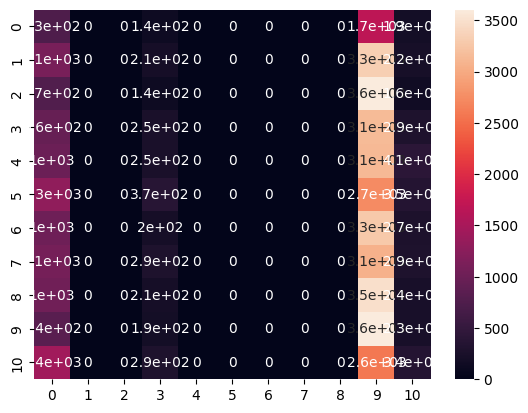

In [75]:
print(classification_report(test['y_test'].to_list(), pred, zero_division=0))
sns.heatmap(confusion_matrix(test['y_test'].to_list(), pred), annot=True)

FastText вообще не может классфицировать тексты, даже близко.  
Скорее всего дело в том, что названия видео не представляют собой связанный текст, в котором можно определеить центральное слово и контекст.  

## Вывод

Нужно было построить классификатор каналов по категориям.  
Для этого мы выгрузили через API описание каналов, последние 50 названий видео, описание этих видео.  
Построили различные модели TFIDF, BERT, FastText.  
Лучше всего показал себя TFIDF, BERT и FastText показали хуже результаты.  
Причиной может быть отсутствие связанности слов в названиях видео.  

### Что можно еще сделать?  
По идее, описания канала и видео мало, для более точной классификации нужно брать сущности из самого видео.  
Это может быть анализ видео ряда, звукового ряда или субтитров.   
Тогда можно использовать более сложные нейросетевые модели для классификации.

In [ ]:
###